![image](https://github.com/IBM/watson-machine-learning-samples/raw/master/cloud/notebooks/headers/AutoAI-Banner_Experiment-Notebook.png)
# Experiment Notebook - AutoAI Notebook v1.15.0


This notebook contains the steps and code to demonstrate support of AutoAI experiments in Watson Machine Learning service. It introduces Python SDK commands for data retrieval, training experiments, persisting pipelines, testing pipelines, refining pipelines, and scoring the resulting model.

**Note:** Notebook code generated using AutoAI will execute successfully. If code is modified or reordered, there is no guarantee it will successfully execute. For details, see: <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/autoai-notebook.html">Saving an Auto AI experiment as a notebook</a>


Some familiarity with Python is helpful. This notebook uses Python 3.7 and `ibm_watson_machine_learning` package.


## Notebook goals

The learning goals of this notebook are:
-  Defining an AutoAI experiment
-  Training AutoAI models 
-  Comparing trained models
-  Deploying the model as a web service
-  Scoring the model to generate predictions.



## Contents

This notebook contains the following parts:

**[Setup](#setup)**<br>
&nbsp;&nbsp;[Package installation](#install)<br>
&nbsp;&nbsp;[Watson Machine Learning connection](#connection)<br>
**[Experiment configuration](#configuration)**<br>
&nbsp;&nbsp;[Experiment metadata](#metadata)<br>
**[Working with completed AutoAI experiment](#work)**<br>
&nbsp;&nbsp;[Get fitted AutoAI optimizer](#get)<br>
&nbsp;&nbsp;[Pipelines comparison](#comparison)<br>
&nbsp;&nbsp;[Get pipeline as scikit-learn pipeline model](#get_pipeline)<br>
&nbsp;&nbsp;[Inspect pipeline](#inspect_pipeline)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Visualize pipeline model](#visualize)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Preview pipeline model as python code](#preview)<br>
**[Deploy and Score](#scoring)**<br>
&nbsp;&nbsp;[Working with spaces](#working_spaces)<br>
**[Running AutoAI experiment with Python SDK](#run)**<br>
**[Clean up](#cleanup)**<br>
**[Next steps](#next_steps)**<br>
**[Copyrights](#copyrights)**

<a id="setup"></a>
# Setup

<a id="install"></a>
## Package installation
Before you use the sample code in this notebook, install the following packages:
 - ibm_watson_machine_learning,
 - autoai-libs,
 - lale,
 - scikit-learn,
 - xgboost,
 - lightgbm.


In [ ]:
!conda remove --force libxgboost -y
!pip install ibm-watson-machine-learning | tail -n 1
!pip install -U autoai-libs==1.12.7 | tail -n 1
!pip install -U 'lale>=0.5.1,<0.6' | tail -n 1
!pip install -U scikit-learn==0.23.2 | tail -n 1
!pip install -U xgboost==1.3.3 | tail -n 1
!pip install -U lightgbm==3.1.1 | tail -n 1

<a id="configuration"></a>
# Experiment configuration

<a id="metadata"></a>
## Experiment metadata
This cell defines the metadata for the experiment, including: training_data_reference, training_result_reference, experiment_metadata.

In [1]:
#@hidden_cell
from ibm_watson_machine_learning.helpers import DataConnection
from ibm_watson_machine_learning.helpers import S3Connection, S3Location

training_data_reference = [DataConnection(
    connection=S3Connection(
        api_key='',
        auth_endpoint='https://iam.bluemix.net/oidc/token/',
        endpoint_url='https://s3-api.us-geo.objectstorage.softlayer.net'
    ),
        location=S3Location(
        bucket='autoaitutorialnew-donotdelete-pr-zhaudczzjfda0e',
        path='german_credit_data.csv'
    )),
]
training_result_reference = DataConnection(
    connection=S3Connection(
        api_key='',
        auth_endpoint='https://iam.bluemix.net/oidc/token/',
        endpoint_url='https://s3-api.us-geo.objectstorage.softlayer.net'
    ),
    location=S3Location(
        bucket='autoaitutorialnew-donotdelete-pr-zhaudczzjfda0e',
        path='auto_ml/509ff920-3fcf-4eb9-9abc-bbc63b4a301a/wml_data/33aa26d1-15eb-482c-93ca-76c186c431a2/data/automl',
        model_location='auto_ml/509ff920-3fcf-4eb9-9abc-bbc63b4a301a/wml_data/33aa26d1-15eb-482c-93ca-76c186c431a2/data/automl/pre_hpo_d_output/Pipeline1/model.pickle',
        training_status='auto_ml/509ff920-3fcf-4eb9-9abc-bbc63b4a301a/wml_data/33aa26d1-15eb-482c-93ca-76c186c431a2/training-status.json'
    ))

In [2]:
experiment_metadata = dict(
   prediction_type='classification',
   prediction_column='Result',
   holdout_size=0.1,
   scoring='accuracy',
   csv_separator=',',
   random_state=33,
   max_number_of_estimators=2,
   training_data_reference=training_data_reference,
   training_result_reference=training_result_reference,
   deployment_url='https://us-south.ml.cloud.ibm.com',
   project_id='0e2a32c8-f2ed-4587-8479-3a22b2ea57b3',
   positive_label=1,
   drop_duplicates=True
)

<a id="connection"></a>
## Watson Machine Learning connection

This cell defines the credentials required to work with the Watson Machine Learning service.

**Action** Please provide IBM Cloud apikey following [docs](https://cloud.ibm.com/docs/account?topic=account-userapikey).

In [3]:
api_key = ''

In [4]:
wml_credentials = {
    "apikey": api_key,
    "url": experiment_metadata['deployment_url']
}

<a id="work"></a>


# Working with completed AutoAI experiment

This cell imports the pipelines generated for the experiment so they can be compared to find the optimal pipeline to save as a model.

<a id="get"></a>


## Get fitted AutoAI optimizer

In [5]:
from ibm_watson_machine_learning.experiment import AutoAI

pipeline_optimizer = AutoAI(wml_credentials, project_id=experiment_metadata['project_id']).runs.get_optimizer(metadata=experiment_metadata)

Use `get_params()`- to retrieve configuration parameters.

In [6]:
pipeline_optimizer.get_params()

{'name': 'Credit Data Analysis',
 'desc': '',
 'prediction_type': 'classification',
 'prediction_column': 'Result',
 'prediction_columns': None,
 'timestamp_column_name': None,
 'scoring': 'accuracy',
 'holdout_size': 0.1,
 'max_num_daub_ensembles': 2.0,
 't_shirt_size': 'a6c4923b-b8e4-444c-9f43-8a7ec3020110',
 'train_sample_rows_test_size': None,
 'include_only_estimators': None,
 'backtest_num': None,
 'lookback_window': None,
 'forecast_window': None,
 'backtest_gap_length': None,
 'cognito_transform_names': None,
 'data_join_graph': False,
 'csv_separator': ',',
 'excel_sheet': 0,
 'encoding': 'utf-8',
 'positive_label': None,
 'drop_duplicates': True,
 'text_processing': None,
 'word2vec_feature_number': None,
 'daub_give_priority_to_runtime': None,
 'run_id': '33aa26d1-15eb-482c-93ca-76c186c431a2'}

<a id="comparison"></a>
## Pipelines comparison

Use the `summary()` method to list trained pipelines and evaluation metrics information in
the form of a Pandas DataFrame. You can use the DataFrame to compare all discovered pipelines and select the one you like for further testing.

In [7]:
summary = pipeline_optimizer.summary()
best_pipeline_name = list(summary.index)[0]
summary

,Enhancements,Estimator,training_roc_auc,holdout_precision,training_average_precision,holdout_average_precision,training_log_loss,holdout_recall,training_precision,holdout_accuracy,holdout_balanced_accuracy,training_recall,holdout_f1,holdout_log_loss,training_accuracy_(optimized),holdout_roc_auc,training_balanced_accuracy,training_f1
Pipeline Name,,,,,,,,,,,,,,,,,,
Pipeline_2,HPO,XGBClassifier,0.766155,0.756757,0.862943,0.809163,0.622273,0.800000,0.811781,0.68,0.600000,0.869841,0.777778,0.724710,0.767778,0.682381,0.699735,0.839790
Pipeline_3,"HPO, FE",XGBClassifier,0.766155,0.756757,0.862943,0.809163,0.622273,0.800000,0.811781,0.68,0.600000,0.869841,0.777778,0.724710,0.767778,0.682381,0.699735,0.839790
Pipeline_4,"HPO, FE",XGBClassifier,0.766155,0.756757,0.862943,0.809163,0.622273,0.800000,0.811781,0.68,0.600000,0.869841,0.777778,0.724710,0.767778,0.682381,0.699735,0.839790
Pipeline_1,,XGBClassifier,0.777372,0.784810,0.874714,0.842136,0.564745,0.885714,0.810742,0.75,0.659524,0.861905,0.832215,0.589836,0.762222,0.732857,0.695767,0.835308
Pipeline_7,"HPO, FE",DecisionTreeClassifier,0.684921,0.736842,0.789945,0.729474,8.941815,0.800000,0.808844,0.66,0.566667,0.825397,0.767123,11.743344,0.741111,0.566667,0.684921,0.816988
Pipeline_8,"HPO, FE",DecisionTreeClassifier,0.684921,0.736842,0.789945,0.729474,8.941815,0.800000,0.808844,0.66,0.566667,0.825397,0.767123,11.743344,0.741111,0.566667,0.684921,0.816988
Pipeline_5,,DecisionTreeClassifier,0.665344,0.740260,0.779152,0.732783,9.479092,0.814286,0.796962,0.67,0.573810,0.815873,0.775510,11.397956,0.725556,0.573810,0.665344,0.806298
Pipeline_6,HPO,DecisionTreeClassifier,0.665344,0.740260,0.779152,0.732783,9.479092,0.814286,0.796962,0.67,0.573810,0.815873,0.775510,11.397956,0.725556,0.573810,0.665344,0.806298


<a id="get_pipeline"></a>
### Get pipeline as scikit-learn pipeline model

After you compare the pipelines, download and save a scikit-learn pipeline model object from the
AutoAI training job.

**Tip:** If you want to get a specific pipeline you need to pass the pipeline name in:
```
pipeline_optimizer.get_pipeline(pipeline_name=pipeline_name)
```

In [8]:
pipeline_model = pipeline_optimizer.get_pipeline(pipeline_name=best_pipeline_name)

Next, check features importance for selected pipeline.

In [9]:
pipeline_optimizer.get_pipeline_details()['features_importance']

,features_importance
Check_Account,1.00
Purpose,0.54
Credit_history,0.38
NewFeature_4_round(Credit amount ),0.36
NewFeature_3_round(Duration),0.34
Saving_account,0.32
NewFeature_1_sqrt(Credit amount ),0.31
Property,0.28
Age,0.28
Present_residence,0.22


**Tip:** If you want to check all model evaluation metrics-details, use:
```
pipeline_optimizer.get_pipeline_details()
```

<a id="inspect_pipeline"></a>
## Inspect pipeline

<a id="visualize"></a>
### Visualize pipeline model

Preview pipeline model stages as a graph. Each node's name links to a detailed description of the stage.


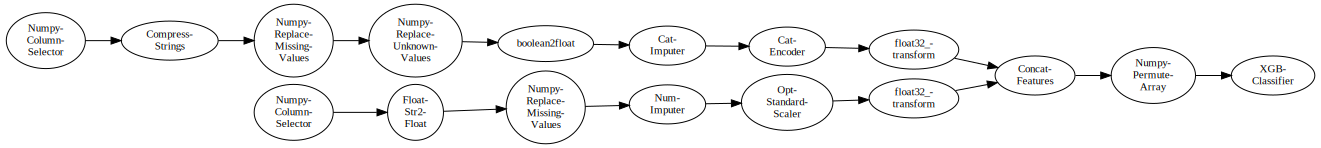

In [10]:
pipeline_model.visualize()

<a id="preview"></a>
### Preview pipeline model as python code
In the next cell, you can preview the saved pipeline model as a python code.  
You will be able to review the exact steps used to create the model.

**Note:** If you want to get sklearn representation add following parameter to `pretty_print` call: `astype='sklearn'`.

In [11]:
pipeline_model.pretty_print(combinators=False, ipython_display=True)

```python
from autoai_libs.transformers.exportable import NumpyColumnSelector
from autoai_libs.transformers.exportable import CompressStrings
from autoai_libs.transformers.exportable import NumpyReplaceMissingValues
from autoai_libs.transformers.exportable import NumpyReplaceUnknownValues
from autoai_libs.transformers.exportable import boolean2float
from autoai_libs.transformers.exportable import CatImputer
from autoai_libs.transformers.exportable import CatEncoder
import numpy as np
from autoai_libs.transformers.exportable import float32_transform
from lale.operators import make_pipeline
from autoai_libs.transformers.exportable import FloatStr2Float
from autoai_libs.transformers.exportable import NumImputer
from autoai_libs.transformers.exportable import OptStandardScaler
from lale.operators import make_union
from autoai_libs.transformers.exportable import NumpyPermuteArray
from xgboost import XGBClassifier

numpy_column_selector_0 = NumpyColumnSelector(
    columns=[
        0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
    ]
)
compress_strings = CompressStrings(
    compress_type="hash",
    dtypes_list=[
        "char_str", "int_num", "char_str", "char_str", "char_str", "char_str",
        "int_num", "char_str", "char_str", "int_num", "char_str", "int_num",
        "char_str", "char_str", "int_num", "char_str", "int_num", "char_str",
        "char_str",
    ],
    missing_values_reference_list=["", "-", "?", float("nan")],
    misslist_list=[
        [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [],
        [], [],
    ],
)
numpy_replace_missing_values_0 = NumpyReplaceMissingValues(
    missing_values=[], filling_values=float("nan")
)
numpy_replace_unknown_values = NumpyReplaceUnknownValues(
    filling_values=float("nan"),
    filling_values_list=[
        float("nan"), float("nan"), float("nan"), float("nan"), float("nan"),
        float("nan"), float("nan"), float("nan"), float("nan"), float("nan"),
        float("nan"), float("nan"), float("nan"), float("nan"), float("nan"),
        float("nan"), float("nan"), float("nan"), float("nan"),
    ],
    missing_values_reference_list=["", "-", "?", float("nan")],
)
cat_imputer = CatImputer(
    strategy="most_frequent",
    missing_values=float("nan"),
    sklearn_version_family="23",
)
cat_encoder = CatEncoder(
    encoding="ordinal",
    categories="auto",
    dtype=np.float64,
    handle_unknown="error",
    sklearn_version_family="23",
)
pipeline_0 = make_pipeline(
    numpy_column_selector_0,
    compress_strings,
    numpy_replace_missing_values_0,
    numpy_replace_unknown_values,
    boolean2float(),
    cat_imputer,
    cat_encoder,
    float32_transform(),
)
numpy_column_selector_1 = NumpyColumnSelector(columns=[4])
float_str2_float = FloatStr2Float(
    dtypes_list=["int_num"], missing_values_reference_list=[]
)
numpy_replace_missing_values_1 = NumpyReplaceMissingValues(
    missing_values=[], filling_values=float("nan")
)
num_imputer = NumImputer(strategy="median", missing_values=float("nan"))
opt_standard_scaler = OptStandardScaler(
    num_scaler_copy=None,
    num_scaler_with_mean=None,
    num_scaler_with_std=None,
    use_scaler_flag=False,
)
pipeline_1 = make_pipeline(
    numpy_column_selector_1,
    float_str2_float,
    numpy_replace_missing_values_1,
    num_imputer,
    opt_standard_scaler,
    float32_transform(),
)
union = make_union(pipeline_0, pipeline_1)
numpy_permute_array = NumpyPermuteArray(
    axis=0,
    permutation_indices=[
        0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 4,
    ],
)
xgb_classifier = XGBClassifier(
    base_score=0.5,
    booster="gbtree",
    colsample_bylevel=1,
    colsample_bynode=1,
    colsample_bytree=1,
    gamma=0,
    gpu_id=-1,
    interaction_constraints="",
    learning_rate=1.0,
    max_delta_step=0,
    max_depth=2,
    min_child_weight=2,
    missing=float("nan"),
    monotone_constraints="()",
    n_estimators=128,
    n_jobs=2,
    num_parallel_tree=1,
    random_state=33,
    reg_alpha=1,
    reg_lambda=1.0,
    scale_pos_weight=1,
    subsample=0.9992297983348898,
    tree_method="hist",
    validate_parameters=1,
    verbosity=0,
    nthread=2,
    silent=True,
    seed=33,
)
pipeline = make_pipeline(union, numpy_permute_array, xgb_classifier)
```

<a id="scoring"></a>
## Deploy and Score

In this section you will learn how to deploy and score the model as a web service.

<a id="working_spaces"></a>
### Working with spaces

In this section you will specify a deployment space for organizing the assets for deploying and scoring the model. If you do not have an existing space, you can use [Deployment Spaces Dashboard](https://dataplatform.cloud.ibm.com/ml-runtime/spaces?context=cpdaas) to create a new space, following these steps:

- Click **New Deployment Space**.
- Create an empty space.
- Select Cloud Object Storage.
- Select Watson Machine Learning instance and press **Create**.
- Copy `space_id` and paste it below.

**Tip**: You can also use the SDK to prepare the space for your work. Learn more [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: assign or update space ID below

### Deployment creation

In [14]:
target_space_id = ""

from ibm_watson_machine_learning.deployment import WebService
service = WebService(source_wml_credentials=wml_credentials,
                     target_wml_credentials=wml_credentials,
                     source_project_id=experiment_metadata['project_id'],
                     target_space_id=target_space_id)
service.create(
model=best_pipeline_name,
metadata=experiment_metadata,
deployment_name='Best_pipeline_webservice'
)

Preparing an AutoAI Deployment...
Published model uid: 71a3a7f8-74e0-4b19-ad65-a20ddd5d4d43
Deploying model 71a3a7f8-74e0-4b19-ad65-a20ddd5d4d43 using V4 client.


#######################################################################################

Synchronous deployment creation for uid: '71a3a7f8-74e0-4b19-ad65-a20ddd5d4d43' started

#######################################################################################


initializing...
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='986e0998-8110-4a76-a8e6-6b9961626a9c'
------------------------------------------------------------------------------------------------




Use the `print` method for the deployment object to show basic information about the service: 

In [15]:
print(service)

name: Best_pipeline_webservice, id: 986e0998-8110-4a76-a8e6-6b9961626a9c, scoring_url: https://us-south.ml.cloud.ibm.com/ml/v4/deployments/986e0998-8110-4a76-a8e6-6b9961626a9c/predictions, asset_id: 71a3a7f8-74e0-4b19-ad65-a20ddd5d4d43


To show all available information about the deployment use the `.get_params()` method:

In [16]:
service.get_params()

{'entity': {'asset': {'id': '71a3a7f8-74e0-4b19-ad65-a20ddd5d4d43'},
  'custom': {},
  'deployed_asset_type': 'model',
  'hardware_spec': {'id': 'c076e82c-b2a7-4d20-9c0f-1f0c2fdf5a24',
   'name': 'M',
   'num_nodes': 1},
  'hybrid_pipeline_hardware_specs': [{'hardware_spec': {'name': 'S',
     'num_nodes': 1},
    'node_runtime_id': 'auto_ai.kb'}],
  'name': 'Best_pipeline_webservice',
  'online': {},
  'space_id': 'd3a9968f-93de-4693-adce-5fb42ba2b068',
  'status': {'online_url': {'url': 'https://us-south.ml.cloud.ibm.com/ml/v4/deployments/986e0998-8110-4a76-a8e6-6b9961626a9c/predictions'},
   'state': 'ready'}},
 'metadata': {'created_at': '2021-06-07T20:45:26.190Z',
  'id': '986e0998-8110-4a76-a8e6-6b9961626a9c',
  'modified_at': '2021-06-07T20:45:26.190Z',
  'name': 'Best_pipeline_webservice',
  'owner': 'IBMid-310001D061',
  'space_id': 'd3a9968f-93de-4693-adce-5fb42ba2b068'}}

### Scoring of webservice
You can make scoring request by calling `score()` on the deployed pipeline.

If you want to work with the web service in an external Python application,follow these steps to retrieve the service object:

 - Initialize the service by `service = WebService(wml_credentials)`
 - Get deployment_id by `service.list()` method
 - Get webservice object by `service.get('deployment_id')` method

After that you can call `service.score()` method.

### Deleting deployment
<a id="cleanup"></a>
You can delete the existing deployment by calling the `service.delete()` command.
To list the existing web services, use `service.list()`.

<a id="run"></a>

## Running AutoAI experiment with Python SDK

If you want to run AutoAI experiment using python API follow up the steps decribed below. The experiment settings were generated basing on parameters set on UI.
 - Go to your COS dashboard.
 - In Service credentials tab, click New Credential.
 - Add the inline configuration parameter: `{“HMAC”:true}`, click Add.
This configuration parameter adds the following section to the instance credentials, (for use later in this notebook):
```
cos_hmac_keys”: {
      “access_key_id”: “***“,
      “secret_access_key”: “***”
 }
 ```

**Action:** Please provide cos credentials in following cells.

- Use provided markdown cells to run code.



```
from ibm_watson_machine_learning.experiment import AutoAI

experiment = AutoAI(wml_credentials, project_id=experiment_metadata['project_id'])
```

```
#@hidden_cell
cos_hmac_keys = {
    "access_key_id": "PLACE_YOUR_ACCESS_KEY_ID_HERE",
    "secret_access_key": "PLACE_YOUR_SECRET_ACCESS_KEY_HERE"
  }
  
cos_api_key = "PLACE_YOUR_API_KEY_HERE"
OPTIMIZER_NAME = 'custom_name'
```

The experiment settings were generated basing on parameters set on UI.

```
from ibm_watson_machine_learning.helpers import DataConnection
from ibm_watson_machine_learning.helpers import S3Connection, S3Location

training_data_reference = [DataConnection(
    connection=S3Connection(
        api_key=cos_api_key,
        auth_endpoint='https://iam.bluemix.net/oidc/token/',
        endpoint_url='https://s3-api.us-geo.objectstorage.softlayer.net',
        access_key_id = cos_hmac_keys['access_key_id'],
        secret_access_key = cos_hmac_keys['secret_access_key']
    ),
        location=S3Location(
        bucket='autoaitutorialnew-donotdelete-pr-zhaudczzjfda0e',
        path='german_credit_data.csv'
    )),
]
from ibm_watson_machine_learning.helpers import S3Connection, S3Location
training_result_reference = DataConnection(
    connection=S3Connection(
        api_key=cos_api_key,
        auth_endpoint='https://iam.bluemix.net/oidc/token/',
        endpoint_url='https://s3-api.us-geo.objectstorage.softlayer.net',
        access_key_id = cos_hmac_keys['access_key_id'],
        secret_access_key = cos_hmac_keys['secret_access_key']
    ),
    location=S3Location(
        bucket='autoaitutorialnew-donotdelete-pr-zhaudczzjfda0e',
        path='auto_ml/509ff920-3fcf-4eb9-9abc-bbc63b4a301a/wml_data/33aa26d1-15eb-482c-93ca-76c186c431a2/data/automl',
        model_location='auto_ml/509ff920-3fcf-4eb9-9abc-bbc63b4a301a/wml_data/33aa26d1-15eb-482c-93ca-76c186c431a2/data/automl/pre_hpo_d_output/Pipeline1/model.pickle',
        training_status='auto_ml/509ff920-3fcf-4eb9-9abc-bbc63b4a301a/wml_data/33aa26d1-15eb-482c-93ca-76c186c431a2/training-status.json'
    ))
```

```
pipeline_optimizer = experiment.optimizer(
    name=OPTIMIZER_NAME,
    prediction_type=experiment_metadata['prediction_type'],
    prediction_column=experiment_metadata['prediction_column'],
    scoring=experiment_metadata['scoring'],
    holdout_size=experiment_metadata['holdout_size'],
    csv_separator=experiment_metadata['csv_separator'],
    positive_label=experiment_metadata['positive_label'],
    drop_duplicates=experiment_metadata['drop_duplicates'])
```

```
pipeline_optimizer.fit(training_data_reference=training_data_reference,
                       training_results_reference=training_result_reference,
                       background_mode=False)
```


<a id="next_steps"></a>
# Next steps

#### [Online Documentation](https://www.ibm.com/cloud/watson-studio/autoai)

<a id="copyrights"></a>
### Copyrights

Licensed Materials - Copyright © 2021 IBM. This notebook and its source code are released under the terms of the ILAN License.
Use, duplication disclosure restricted by GSA ADP Schedule Contract with IBM Corp.

**Note:** The auto-generated notebooks are subject to the International License Agreement for Non-Warranted Programs (or equivalent) and License Information document for Watson Studio Auto-generated Notebook (License Terms), such agreements located in the link below. Specifically, the Source Components and Sample Materials clause included in the License Information document for Watson Studio Auto-generated Notebook applies to the auto-generated notebooks.  

By downloading, copying, accessing, or otherwise using the materials, you agree to the <a href="http://www14.software.ibm.com/cgi-bin/weblap/lap.pl?li_formnum=L-AMCU-BYC7LF">License Terms</a>  

___